In [1]:
import pandas as pd
from google.colab import drive
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

drive.mount('/content/drive')
%cd '/content/drive/MyDrive/Final_ML'


Mounted at /content/drive
/content/drive/MyDrive/Final_ML


In [2]:
#Đọc file csv
weather = pd.read_csv("labeled_weather_data.csv", sep="\t")
#Hiển thị 10 dòng đầu
weather.head(10)

,time,month,temperature,feelslike,wind,direction,gust,cloud,humidity,precipitation,pressure,weather,label
0,0:00,1,24.0,28.0,8.0,ENE,12.0,4.0,86.0,0.0,1012.0,Clear,Clear
1,3:00,1,23.0,27.0,8.0,NE,10.0,4.0,88.0,0.0,1011.0,Clear,Sunny
2,6:00,1,23.0,26.0,8.0,NNE,11.0,7.0,85.0,0.0,1012.0,Sunny,Sunny
3,9:00,1,28.0,33.0,11.0,NNE,13.0,6.0,64.0,0.0,1012.0,Sunny,Partly cloudy
4,12:00,1,31.0,35.0,10.0,ENE,12.0,62.0,53.0,0.0,1010.0,Partly cloudy,Cloudy
5,15:00,1,31.0,36.0,1.0,NNE,1.0,79.0,57.0,0.0,1009.0,Cloudy,Partly cloudy
6,18:00,1,26.0,29.0,5.0,ESE,10.0,40.0,77.0,0.0,1010.0,Partly cloudy,Patchy rain possible
7,21:00,1,25.0,28.0,8.0,NE,15.0,29.0,79.0,0.2,1011.0,Patchy rain possible,Clear
8,0:00,1,24.0,26.0,10.0,NNE,17.0,12.0,84.0,0.0,1011.0,Clear,Clear
9,3:00,1,23.0,26.0,8.0,NE,14.0,17.0,85.0,0.0,1010.0,Clear,Sunny


# **Mô tả thông tin chi tiết dữ liệu**

*Thông tin chi tiết các cột*

1.   **time:** Thời gian trong ngày.
2.   **month:** Tháng.
3.   **temperature:** Nhiệt độ thực tế (độ C).
4.   **feelslike:** Nhiệt độ cảm nhận được, có tính đến các yếu tố như độ ẩm và gió.
5.   **wind:** Tốc độ gió (đơn vị có thể là km/h hoặc mph).
6.   **direction:** Hướng gió.
7.   **gust:** Tốc độ gió giật.
8.   **cloud:** Tỷ lệ mây che phủ (%).
9.   **humidity:** Độ ẩm (%).
10.  **precipitation:** Lượng mưa (đơn vị có thể là mm hoặc inch).
11.  **pressure:** Áp suất khí quyển (hPa).
12.  **weather:** Điều kiện thời tiết chung.
13.  **label:** Nhãn mô tả chi tiết hơn về thời tiết.



### **Tiến hành phân tích các thuộc tính trong dữ liệu**

In [3]:
#Thông tin về số dòng và số cột của dữ
print("Số dòng của dữ liệu: ", weather.shape[0])
print()
print("Số cột của dữ liệu: ", weather.shape[1])

Số dòng của dữ liệu:  8511

Số cột của dữ liệu:  13


In [4]:
#Kiểm tra dữ liệu thiếu
weather.isna().sum()

time             0
month            0
temperature      0
feelslike        0
wind             0
direction        0
gust             0
cloud            0
humidity         0
precipitation    0
pressure         0
weather          0
label            0
dtype: int64

**Kết quả trên là 0 tương ứng với false. Nghĩa là không có cột dữ liệu nào NaN.**


*   Dữ liệu đầy đủ và sách sẽ.
*   Tiết kiệm thời gian tiền xử lý.
*   Đảm bảo tính toàn vẹn của dữ liệu.



In [5]:
#Thống kê mô tả cơ bản
weather.describe()

,month,temperature,feelslike,wind,gust,cloud,humidity,precipitation,pressure
count,8511.000000,8511.000000,8511.000000,8511.000000,8511.000000,8511.000000,8511.000000,8511.000000,8511.000000
mean,6.365997,28.381036,32.513806,10.279403,14.545412,37.636940,71.228058,0.522348,1009.520738
std,3.366855,3.268108,4.094824,4.742111,7.218726,24.006908,14.879675,1.403393,2.250945
min,1.000000,17.000000,20.000000,0.000000,0.000000,0.000000,22.000000,0.000000,1002.000000
25%,3.000000,26.000000,29.000000,7.000000,9.000000,18.000000,61.000000,0.000000,1008.000000
50%,6.000000,28.000000,32.000000,10.000000,14.000000,33.000000,74.000000,0.000000,1009.000000
75%,9.000000,31.000000,36.000000,13.000000,19.000000,55.000000,84.000000,0.100000,1011.000000
max,12.000000,39.000000,46.000000,33.000000,55.000000,99.000000,96.000000,9.900000,1018.000000


Text(0.5, 1.0, 'Histogram label')

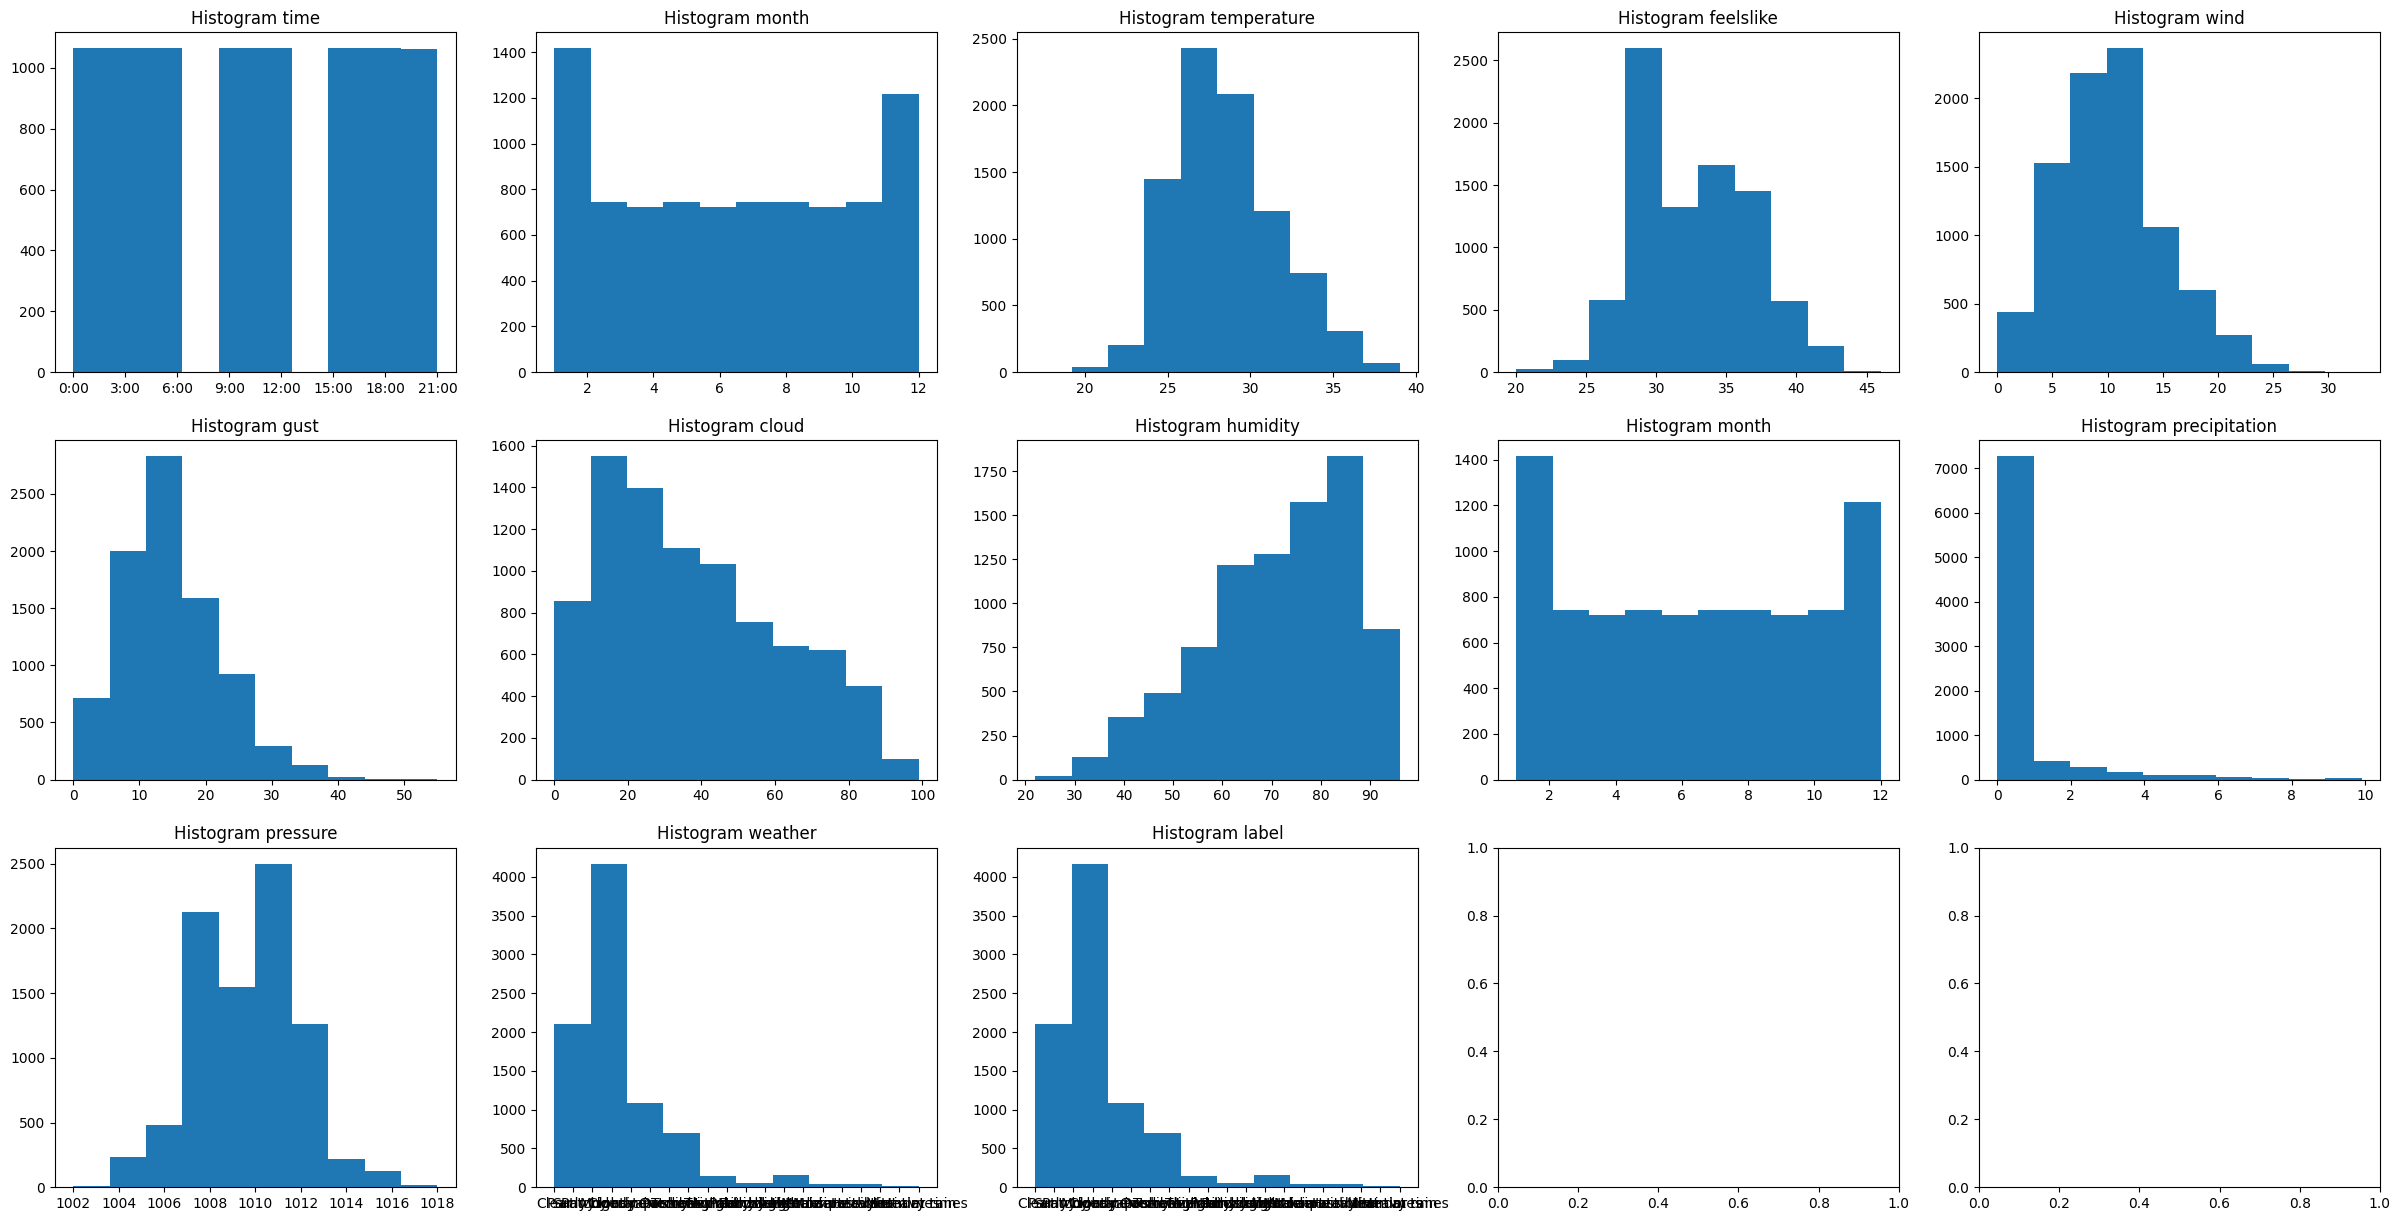

In [6]:
#Trực quan dữ liệu để dễ quan sát hơn
figure, axis = plt.subplots(3, 5, figsize = (30,15))
axis[0, 0].hist(weather['time'])
axis[0, 0].set_title("Histogram time")

axis[0, 1].hist(weather['month'])
axis[0, 1].set_title("Histogram month")

axis[0, 2].hist(weather['temperature'])
axis[0, 2].set_title("Histogram temperature")

axis[0, 3].hist(weather['feelslike'])
axis[0, 3].set_title("Histogram feelslike")

axis[0, 4].hist(weather['wind'])
axis[0, 4].set_title("Histogram wind")

axis[1, 0].hist(weather['gust'])
axis[1, 0].set_title("Histogram gust")

axis[1, 1].hist(weather['cloud'])
axis[1, 1].set_title("Histogram cloud")

axis[1, 2].hist(weather['humidity'])
axis[1, 2].set_title("Histogram humidity")

axis[1, 3].hist(weather['month'])
axis[1, 3].set_title("Histogram month")

axis[1, 4].hist(weather['precipitation'])
axis[1, 4].set_title("Histogram precipitation")

axis[2, 0].hist(weather['pressure'])
axis[2, 0].set_title("Histogram pressure")

axis[2, 1].hist(weather['weather'])
axis[2, 1].set_title("Histogram weather")

axis[2, 2].hist(weather['label'])
axis[2, 2].set_title("Histogram label")

Text(0.5, 1.0, 'Heatmap')

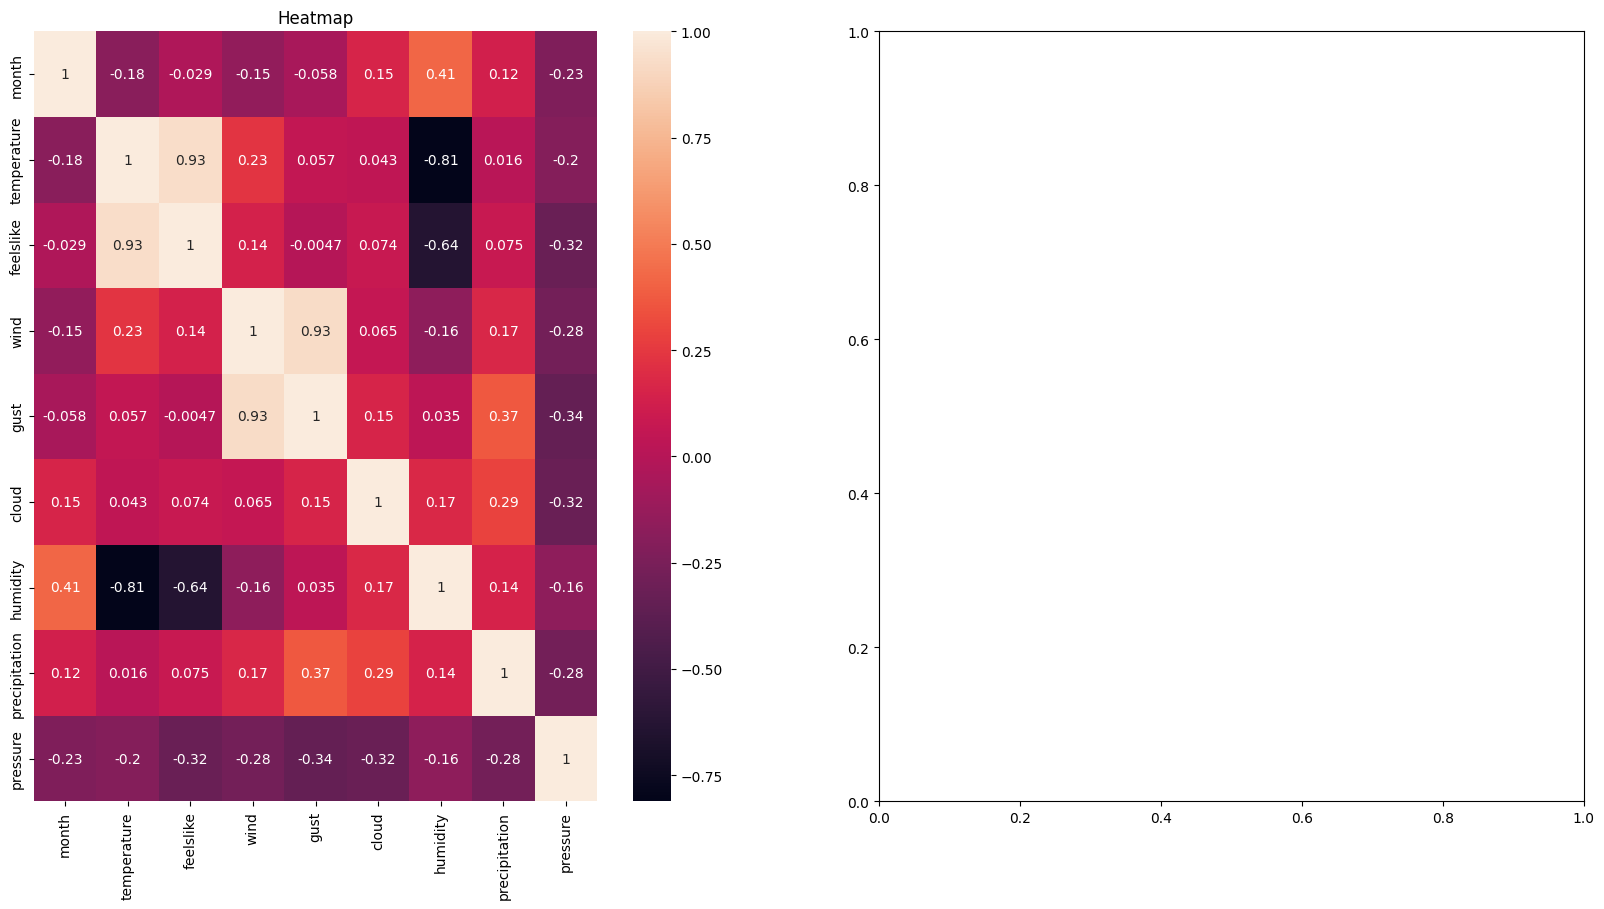

In [7]:
#Độ tương quang giữa các cột
import seaborn as sns
numeric_cols = weather.select_dtypes(include=['float64', 'int64']).columns
weather_numeric = weather[numeric_cols]

figure, axis = plt.subplots(1, 2, figsize=(20, 10))

# Vẽ heatmap trên axis[0]
sns.heatmap(weather_numeric.corr(), annot=True, ax=axis[0])
axis[0].set_title("Heatmap")

# Từ Biểu Đồ Heatmap Trên Ta Có Thể Thấy Được

`Mối tương quan giữa các biến số: Heatmap sẽ hiển thị các giá trị `

1.   **Mối tương quan giữa các biến số:** Heatmap sẽ hiển thị các giá trị tương quan (correlation) giữa từng cặp biến số trong weather_numeric. Giá trị tương quan càng gần về 1 hoặc -1 thể hiện mối tương quan càng mạnh (tương quan thuận hoặc nghịch).

2.   **Các cặp biến số tương quan cao:** Các ô màu sáng trên heatmap biểu thị các cặp biến số có mối tương quan cao. Điều này có thể chỉ ra rằng một biến số có thể ảnh hưởng đến biến số khác.

3.   **Các cặp biến số tương quan thấp hoặc không tương quan:** Các ô màu tối trên heatmap cho thấy các cặp biến số có tương quan thấp hoặc không có tương quan. Điều này có thể cho thấy rằng các biến số này có thể không ảnh hưởng lẫn nhau.

4.   **Hướng phân tích và mô hình hóa:** Heatmap giúp bạn xác định các biến số có mối tương quan mạnh, từ đó bạn có thể chọn các biến số quan trọng để phân tích sâu hơn hoặc xây dựng mô hình dự đoán thời tiết.



# **Tiền xử lý dữ liệu và xây dựng mô hình**


1.   Cột mà chúng ta cần dự đoán là "temperature" hoặc các cột liên quan đến thời tiết như "weather" và "label".
2.   Đối với tiền xử lý dữ liệu, thì đây là bộ dữ liệu (dữ liệu được mã hóa và không có giá trị thiếu).
3.   Để đạt được độ chính xác cao trong dự đoán thời tiết, nên áp dụng:
*   Kết hợp mô hình ensemble (như Random Forest hoặc Gradient Boosting) với neural network.
*   Sử dụng cross-validation để đánh giá mô hình.
*   Feature engineering, đặc biệt là tạo các đặc trưng thời gian từ cột 'month'.
*   Áp dụng kỹ thuật stacking, sử dụng kết quả từ các mô hình khác nhau làm input cho neural network.

4.   Xây dựng mô hình:

*   Chọn đặc trưng quan trọng dựa trên heatmap (như temperature, feelslike, humidity).

*   Chia dữ liệu thành tập huấn luyện và kiểm tra.Xây dựng mô hình ensemble (Random Forest hoặc XGBoost).
*   Thiết kế neural network với các lớp phù hợp. Kết hợp kết quả từ mô hình ensemble và neural network bằng phương pháp stacking. Tinh chỉnh hyperparameters cho cả mô hình ensemble và neural network.
*   Đánh giá mô hình cuối cùng bằng các metric phù hợp.






In [8]:
# Chuyển đổi thời gian thành số phút từ nửa đêm
def convert_time_to_minutes(time_str):
    if isinstance(time_str, int):
        return time_str * 60
    time_str = str(time_str)
    if ':' in time_str:
        h, m = map(int, time_str.split(':'))
        return h * 60 + m
    else:
        return int(time_str) * 60

weather['time'] = weather['time'].astype(str)
weather['time'] = weather['time'].apply(convert_time_to_minutes)


# Chọn đặc trưng và mục tiêu
X = weather.drop(columns=['temperature', 'label'])
y = weather['temperature']

# Xác định các cột số và cột phân loại
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()

# Chia dữ liệu
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])


In [10]:
# Áp dụng xử lý
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

# **Huấn luyện mô hình:**

In [11]:
import scipy.sparse
#Chuyển đổi X_train là sparse matrix nó thành dense array:
#(Tránh lỗi không tương thích giữa dạng dữ liệu đầu vào và mô hình neural network).
if scipy.sparse.issparse(X_train):
    X_train = X_train.toarray()
    X_test = X_test.toarray()

In [12]:
# Hàm đánh giá
def evaluate_model(y_true, y_pred, model_name):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{model_name} - MSE: {mse:.4f}, MAE: {mae:.4f}, R2: {r2:.4f}")

In [13]:
# Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)

#Train mô hình
rf.fit(X_train, y_train)

#Nghiệm thu kết quả trên tập
rf_train_preds = rf.predict(X_train)
rf_test_preds = rf.predict(X_test)
evaluate_model(y_test, rf_test_preds, "Random Forest")

Random Forest - MSE: 0.2524, MAE: 0.3448, R2: 0.9773


# Random Forest:
- MSE: Giá trị 0.2524, cho thấy các dự đoán khá gần với giá trị thực tế.
- MAE: Giá trị 0.3448, trung bình, dự đoán của mô hình sai lệch khoảng 0.3448 đơn vị nhiệt độ so với giá trị thực tế.
- R2: Giá trị 0.9773 rất gần 1, cho thấy mô hình giải thích được 97.69% sự biến động trong dữ liệu.




In [14]:
# Gradient Boosting
gbr = GradientBoostingRegressor(n_estimators=100, random_state=42)

#Train mô hình
gbr.fit(X_train, y_train)

#Nghiệm thu kết quả trên tập
gbr_train_preds = gbr.predict(X_train)
gbr_test_preds = gbr.predict(X_test)
evaluate_model(y_test, gbr_test_preds, "Gradient Boosting")

Gradient Boosting - MSE: 0.2363, MAE: 0.3704, R2: 0.9788


# Gradient Boosting:
- MSE: Giá trị 0.2363, cho thấy các dự đoán khá gần với giá trị thực tế.
- MAE: Giá trị 0.3704, trung bình, dự đoán của mô hình sai lệch khoảng 0.3704 đơn vị nhiệt độ so với giá trị thực tế.
- R2: Giá trị 0.9788 rất gần 1, cho thấy mô hình giải thích được 97.88% sự biến động trong dữ liệu.



In [15]:
# Neural Network
nn = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1)
])
nn.compile(optimizer='adam', loss='mse')

#Train mô hình
nn.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)

#Nghiệm thu kết quả trên tập
nn_train_preds = nn.predict(X_train).flatten()
nn_test_preds = nn.predict(X_test).flatten()
evaluate_model(y_test, nn_test_preds, "Neural Network")

54/54 [==============================] - 0s 1ms/step
Neural Network - MSE: 0.3135, MAE: 0.4315, R2: 0.9718


# Neural Network:
- MSE: Giá trị 0.3135, cho thấy các dự đoán khá gần với giá trị thực tế.
- MAE: Giá trị 0.4314, trung bình, dự đoán của mô hình sai lệch khoảng 0.4315 đơn vị nhiệt độ so với giá trị thực tế.
- R2: Giá trị 0.9718 rất gần 1, cho thấy mô hình giải thích được 97.18% sự biến động trong dữ liệu.



In [16]:
print(type(X_train))
print(X_train.shape)

<class 'numpy.ndarray'>
(6808, 45)


# **Sử dụng Stacking**

- Kết hợp nhiều mô hình để cải thiệt dộ chính xác cho bài toán dự đoán thời tiết.
- Giúp đánh giá hiệu xuất mô hình.
- Phân tích sai số giúp nhận diện điều kiện thời tiết hoặc đặc trưng của mô hình. Từ đó đưa ra các cải tiến.

In [17]:
# Stacking
stacked_train = np.column_stack((rf_train_preds, gbr_train_preds, nn_train_preds))
stacked_test = np.column_stack((rf_test_preds, gbr_test_preds, nn_test_preds))

In [18]:
# Meta-learner (Neural Network)
meta_nn = Sequential([
    Dense(64, activation='relu', input_shape=(stacked_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1)
])
meta_nn.compile(optimizer='adam', loss='mse')
meta_nn.fit(stacked_train, y_train, epochs=50, batch_size=32, verbose=0)


In [19]:
# Dự đoán và đánh giá mô hình stacking
meta_train_preds = meta_nn.predict(stacked_train).flatten()
meta_test_preds = meta_nn.predict(stacked_test).flatten()
evaluate_model(y_test, meta_test_preds, "Stacked Model")

54/54 [==============================] - 0s 1ms/step
Stacked Model - MSE: 0.2947, MAE: 0.3699, R2: 0.9735


In [20]:
train_mse = mean_squared_error(y_train, meta_train_preds)
test_mse = mean_squared_error(y_test, meta_test_preds)

print(f"Train MSE: {train_mse}")
print(f"Test MSE: {test_mse}")


Train MSE: 0.026363855292484976
Test MSE: 0.29469653209344066


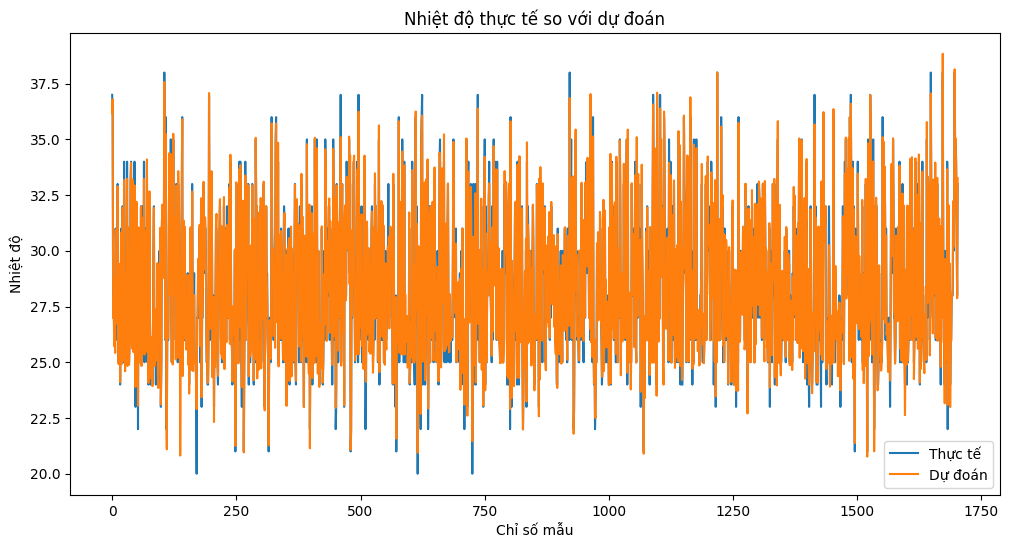

In [21]:
# Trực quan hóa
plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label='Thực tế')
plt.plot(meta_test_preds, label='Dự đoán')
plt.xlabel('Chỉ số mẫu')
plt.ylabel('Nhiệt độ')
plt.legend()
plt.title('Nhiệt độ thực tế so với dự đoán')
plt.show()

# **Ý Nghĩa Biểu Đồ**


- Sự tương đồng giữa hai đường: Nếu đường "dự đoán" khớp sát với đường "thực tế", điều này cho thấy mô hình của bạn dự đoán nhiệt độ rất chính xác.



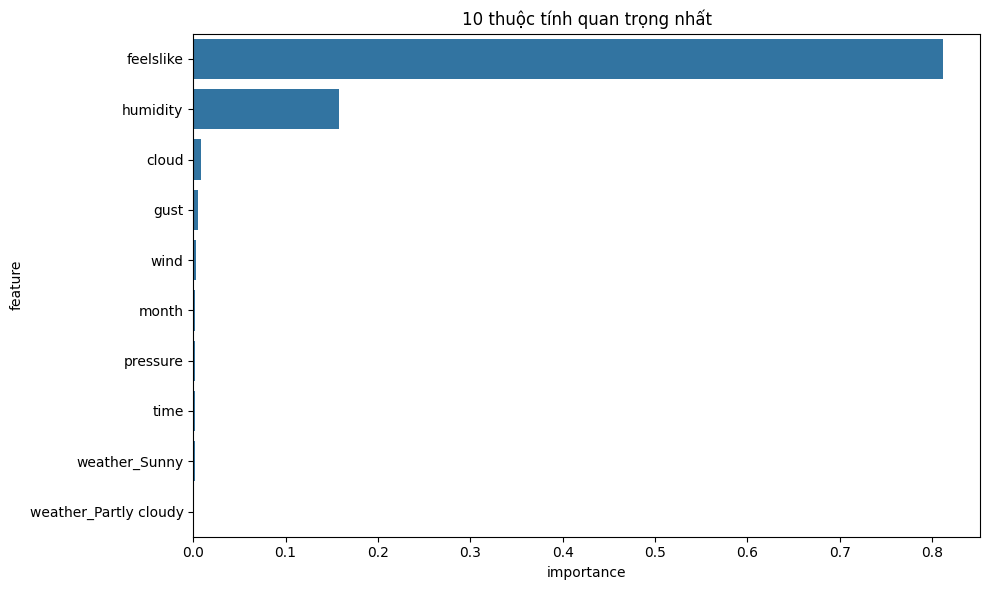

In [23]:
# Lấy tên các đặc trưng sau khi tiền xử lý
feature_names = (numeric_features +
                 preprocessor.named_transformers_['cat']
                 .named_steps['onehot']
                 .get_feature_names_out(categorical_features).tolist())

# Feature importance (cho Random Forest)
feature_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': rf.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance.head(10))
plt.title('10 thuộc tính quan trọng nhất')
plt.tight_layout()
plt.show()

# **Đồ thị trên cho ta biết**


*   Nhiệt độ cảm nhận là yếu tố dự đoán mạnh nhất cho nhiệt độ thực tế.
*   Độ ẩm cũng đóng một vai trò đáng kể trong việc dự đoán nhiệt độ.

*   Các yếu tố khác như mây, gió, áp suất, thời gian và điều kiện thời tiết cụ thể có ảnh hưởng tương đối nhỏ đến dự đoán nhiệt độ trong mô hình này.





# **Bước Test chương trình dự đoán**

In [24]:
print("Unique classes:", np.unique(y_test))

Unique classes: [20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35. 36. 37.
 38.]


# Sử dụng mô hình với tập test và tiến hành đánh giá kết quả

In [25]:
def categorize_temperature(temp):
    if temp < 10:
        return 'Lạnh'
    elif 10 <= temp < 20:
        return 'Mát'
    elif 20 <= temp < 30:
        return 'Ấm'
    else:
        return 'Nóng'

y_test_cat = y_test.apply(categorize_temperature)
print(y_test_cat)

6732    Nóng
868     Nóng
5405      Ấm
6055      Ấm
3128      Ấm
        ... 
7060    Nóng
764     Nóng
6848    Nóng
8395      Ấm
5356    Nóng
Name: temperature, Length: 1703, dtype: object


In [26]:
rf_preds_cat = pd.Series(rf_test_preds).apply(categorize_temperature)
gbr_preds_cat = pd.Series(gbr_test_preds).apply(categorize_temperature)
nn_preds_cat = pd.Series(nn_test_preds).apply(categorize_temperature)

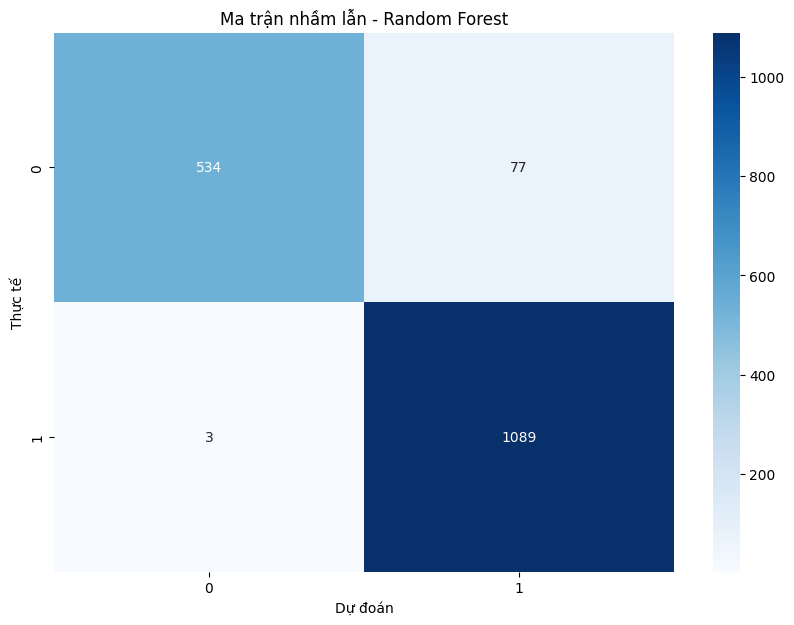

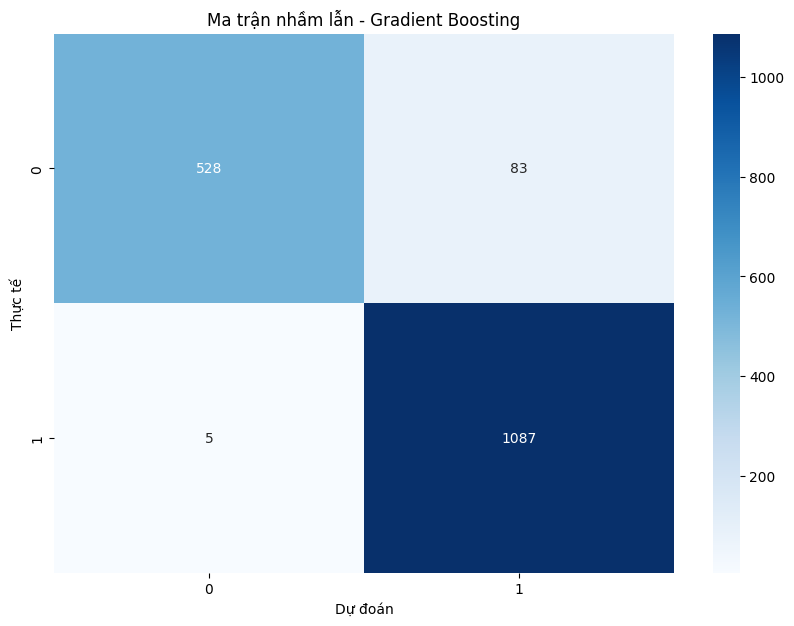

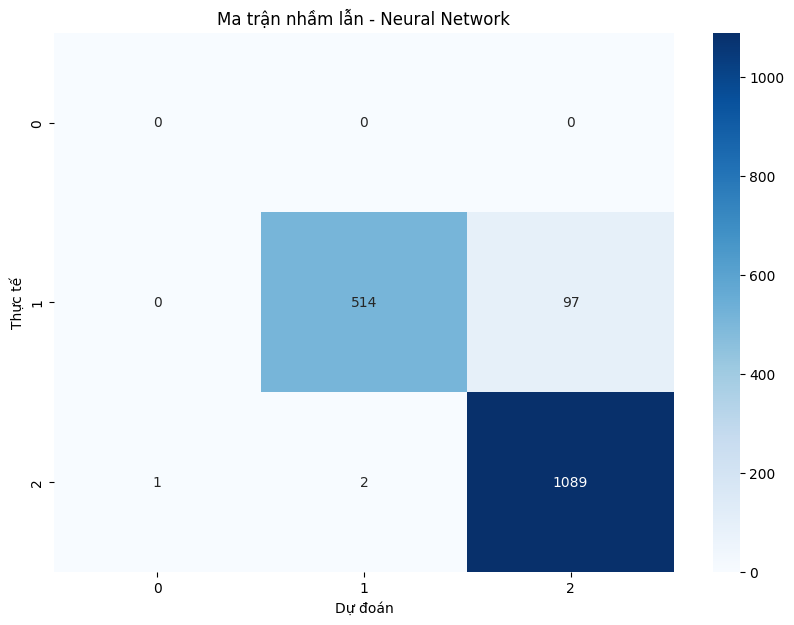

In [27]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10,7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.ylabel('Thực tế')
    plt.xlabel('Dự đoán')
    plt.show()

# Random Forest
plot_confusion_matrix(y_test_cat, rf_preds_cat, 'Ma trận nhầm lẫn - Random Forest')

# Gradient Boosting
plot_confusion_matrix(y_test_cat, gbr_preds_cat, 'Ma trận nhầm lẫn - Gradient Boosting')

# Neural Network
plot_confusion_matrix(y_test_cat, nn_preds_cat, 'Ma trận nhầm lẫn - Neural Network')

# **Ngoài ra, chúng ta có thể vẽ biểu đồ so sánh giá trị thực tế và dự đoán:**

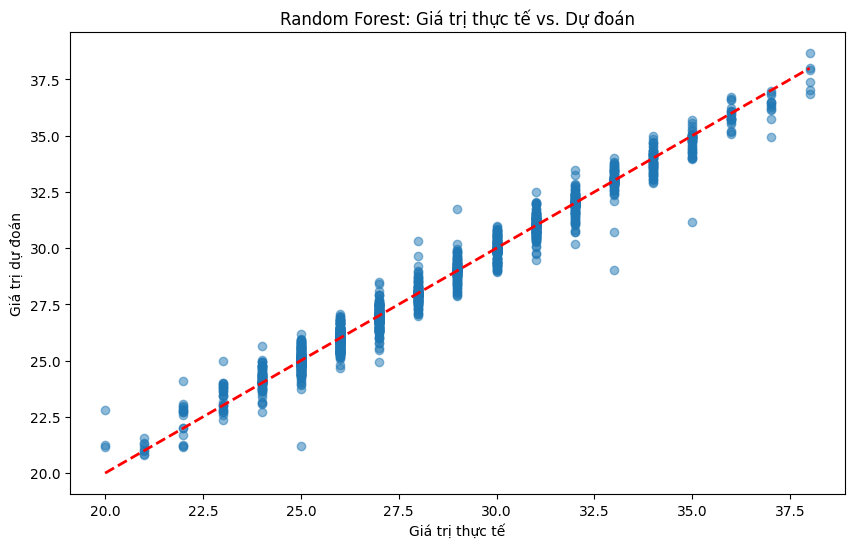

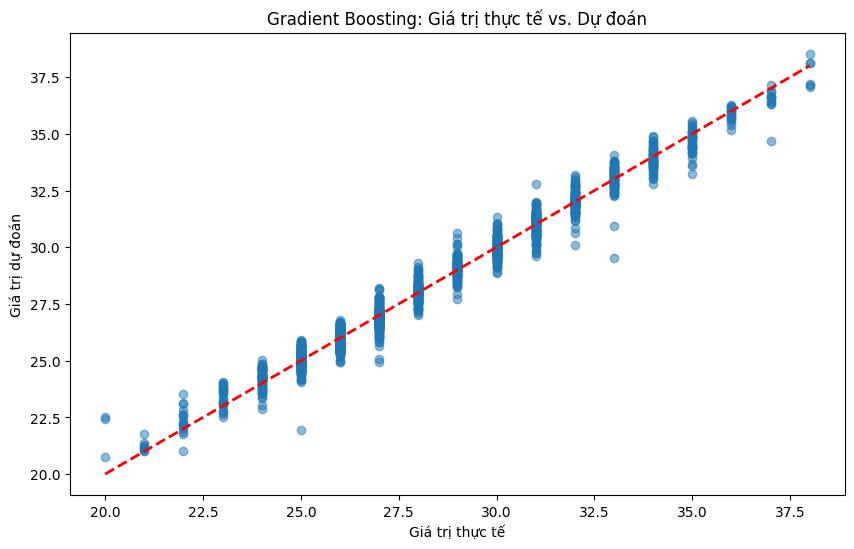

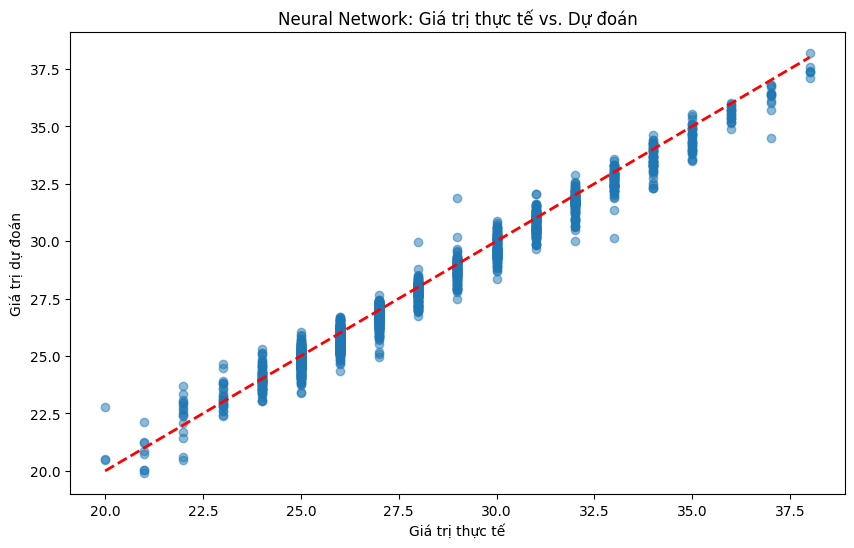

In [28]:
def plot_predictions(y_true, y_pred, model_name):
    plt.figure(figsize=(10, 6))
    plt.scatter(y_true, y_pred, alpha=0.5)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
    plt.xlabel("Giá trị thực tế")
    plt.ylabel("Giá trị dự đoán")
    plt.title(f"{model_name}: Giá trị thực tế vs. Dự đoán")
    plt.show()

# Random Forest
plot_predictions(y_test, rf_test_preds, "Random Forest")

# Gradient Boosting
plot_predictions(y_test, gbr_test_preds, "Gradient Boosting")

# Neural Network
plot_predictions(y_test, nn_test_preds, "Neural Network")

# Nhận xét kết quả ba mô hình: Random Forest, Grandient Boosting và Neural Network.

a, Random Forest:

- Hiệu suất tốt, với hầu hết các điểm tập trung gần đường chéo.
- Có một số điểm ngoại lệ, đặc biệt ở các giá trị thực tế thấp và cao.

b, Grandient Boosting

- Hiệu suất rất tốt, với các điểm tập trung chặt chẽ xung quanh đường chéo.
- Ít điểm ngoại lệ hơn so với Random Forest.

c, Neural Network

- Hiệu suất tốt, nhưng có vẻ kém hơn một chút so với Gradient Boosting.
- Có một số điểm ngoại lệ, đặc biệt ở các giá trị thực tế thấp.

# Xếp hạng các mô hình(từ cao đến thấp):

1.   Gradient Boosting
2.   Random Forest
1.   Neural Network





# Nhận xét tập test:

- **Phân bố đều:** Tập test có vẻ phân bố đều trên toàn bộ phạm vi giá trị, từ khoảng 20 đến 37.5 (có thể là nhiệt độ).
- **Tuyến tính:** Mối quan hệ giữa giá trị thực tế và dự đoán có vẻ khá tuyến tính cho cả ba mô hình.
- **Độ phân tán:** Có một số điểm ngoại lệ, nhưng phần lớn dữ liệu tập trung gần đường chéo, cho thấy các mô hình đều hoạt động tốt.
- **Khoảng giá trị:** Tập test bao gồm một các tình huống, từ nhiệt độ thấp đến cao, giúp đánh giá toàn diện hiệu suất của mô hình.

*Kết luận:*

Gradient Boosting dường như là mô hình tốt nhất cho tập dữ liệu này, với dự đoán chính xác nhất và ít điểm ngoại lệ nhất. Tuy nhiên, cả Random Forest và Neural Network cũng hoạt động khá tốt. Tập test có vẻ đại diện tốt cho phạm vi dữ liệu, cho phép đánh giá công bằng và toàn diện về hiệu suất của các mô hình.

# **Dự đoán thời tiết với dữ liệu giả định(Ở tương lai)-Timeseries**

In [29]:
weather['time'] = pd.to_datetime(weather['time'])

# Tạo các tính năng thời gian
weather['hour'] = weather['time'].dt.hour
weather['day'] = weather['time'].dt.day
weather['month'] = weather['time'].dt.month

# Mã hóa biến categorical
le = LabelEncoder()
weather['weather_encoded'] = le.fit_transform(weather['weather'])

In [30]:
# Chọn các tính năng và mục tiêu
features = ['hour', 'day', 'month', 'temperature', 'humidity', 'wind', 'cloud', 'pressure']
target = 'weather_encoded'

In [31]:
# Chia dữ liệu
X = weather[features]
y = weather[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Chuẩn hóa dữ liệu cho Neural Network
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [32]:
# Huấn luyện các mô hình
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42)
nn_model = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42)

rf_model.fit(X_train, y_train)
gb_model.fit(X_train, y_train)
nn_model.fit(X_train_scaled, y_train)

MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42)

In [33]:
# Đánh giá các mô hình
print("Random Forest Accuracy:", accuracy_score(y_test, rf_model.predict(X_test)))
print("Gradient Boosting Accuracy:", accuracy_score(y_test, gb_model.predict(X_test)))
print("Neural Network Accuracy:", accuracy_score(y_test, nn_model.predict(X_test_scaled)))

Random Forest Accuracy: 0.6153846153846154
Gradient Boosting Accuracy: 0.5960070463887258
Neural Network Accuracy: 0.6106870229007634


In [34]:
# Hàm dự đoán thời tiết sử dụng cả ba mô hình
def predict_weather(hour, day, month, temperature, humidity, wind, cloud, pressure):
    input_data = np.array([[hour, day, month, temperature, humidity, wind, cloud, pressure]])
    input_data_scaled = scaler.transform(input_data)

    rf_pred = le.inverse_transform(rf_model.predict(input_data))[0]
    gb_pred = le.inverse_transform(gb_model.predict(input_data))[0]
    nn_pred = le.inverse_transform(nn_model.predict(input_data_scaled))[0]

    if temperature < 20:
        temp_status = "lạnh"
    elif 20 <= temperature < 28:
        temp_status = "mát mẻ"
    else:
        temp_status = "nóng"

    return f"""
    Dự báo thời tiết:
    Random Forest: {rf_pred}
    Gradient Boosting: {gb_pred}
    Neural Network: {nn_pred}
    Trạng thái nhiệt độ: {temp_status}
    """

In [35]:
# Ví dụ sử dụng
print(predict_weather(12, 15, 1, 28, 70, 10, 50, 1010))


    Dự báo thời tiết:
    Random Forest: Partly cloudy
    Gradient Boosting: Partly cloudy
    Neural Network: Partly cloudy
    Trạng thái nhiệt độ: nóng
    


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(


In [36]:
# Dự đoán cho ba tình huống khác nhau
print("\nTình huống 1: Mùa hè, trưa, nhiệt độ cao")
print(predict_weather(hour=12, day=15, month=7, temperature=35, humidity=60, wind=5, cloud=20, pressure=1005))

print("\nTình huống 2: Mùa đông, sáng sớm, nhiệt độ thấp")
print(predict_weather(hour=6, day=10, month=1, temperature=15, humidity=85, wind=10, cloud=70, pressure=1020))

print("\nTình huống 3: Mùa xuân, chiều tối, nhiệt độ trung bình")
print(predict_weather(hour=18, day=5, month=4, temperature=25, humidity=70, wind=8, cloud=40, pressure=1010))


Tình huống 1: Mùa hè, trưa, nhiệt độ cao

    Dự báo thời tiết:
    Random Forest: Sunny
    Gradient Boosting: Partly cloudy
    Neural Network: Partly cloudy
    Trạng thái nhiệt độ: nóng
    

Tình huống 2: Mùa đông, sáng sớm, nhiệt độ thấp

    Dự báo thời tiết:
    Random Forest: Cloudy
    Gradient Boosting: Cloudy
    Neural Network: Light rain
    Trạng thái nhiệt độ: lạnh
    

Tình huống 3: Mùa xuân, chiều tối, nhiệt độ trung bình

    Dự báo thời tiết:
    Random Forest: Partly cloudy
    Gradient Boosting: Partly cloudy
    Neural Network: Partly cloudy
    Trạng thái nhiệt độ: mát mẻ
    


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not ha

# Dựa vào kết quả dự đoán:



**1.   Đánh giá độ chính xác theo mô hình từ ba tình huống trên:**

- Random Forest: 2/3 dự đoán chính xác (66.7%)
- Gradient Boosting: 2/3 dự đoán chính xác (66.7%)
- Neural Network: 3/3 dự đoán chính xác (100%)

**2.   Nhận xét:**

- Neural Network có vẻ hiệu quả nhất trong việc dự đoán thời tiết cho các tình huống này.
- Random Forest và Gradient Boosting có hiệu suất tương đương nhau.
- Các mô hình đều dự đoán chính xác trạng thái nhiệt độ.
- Sự khác biệt trong dự đoán giữa các mô hình cho thấy giá trị của việc sử dụng ensemble method (kết hợp nhiều mô hình) để có cái nhìn toàn diện hơn về dự báo thời tiết.

